### Standart imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split

from sklearn.preprocessing import LabelEncoder, RobustScaler

from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# read data
red = pd.read_csv('Red.csv')
white = pd.read_csv('White.csv')
sparkling = pd.read_csv('Sparkling.csv')
rose = pd.read_csv('Rose.csv')

In [3]:
red.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016


# 1) Data preparation

At modeling step, i would like to work with data as single data frame.<br>
Let's join our data and make binary feature for wine styles.

In [4]:
red['WineStyle'] = 'red'
white['WineStyle'] = 'white'
sparkling['WineStyle'] = 'sparkling'
rose['WineStyle'] = 'rose'
wines =  pd.concat([red, white, sparkling, rose], ignore_index=True)

In [5]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13834 entries, 0 to 13833
Data columns (total 9 columns):
Name               13834 non-null object
Country            13834 non-null object
Region             13834 non-null object
Winery             13834 non-null object
Rating             13834 non-null float64
NumberOfRatings    13834 non-null int64
Price              13834 non-null float64
Year               13834 non-null object
WineStyle          13834 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 972.8+ KB


Data is quite clear, I only want to convert year feature from object to integer for plotting and modeling

In [6]:
# N.V. wines is a nonvintage wine, which is usually a blend from the produce of two or more years
# we can choose any free number to encode it

wines['Year'] = wines['Year'].replace('N.V.', 2030) # it's important, that there were no 2030 year wines in list before
wines['Year'] = wines['Year'].astype('int')

# 2) EDA

Firstly, will look for general info

In [7]:
wines.sample(frac=1).head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,WineStyle
12209,Mâcon-Villages Blanc 2018,France,Mâcon-Villages,Louis Jadot,3.8,536,14.54,2018,white
6269,Merlot 2016,Italy,Südtirol - Alto Adige,Alois Lageder,3.6,54,11.90,2016,red
13035,Blanc de Noirs Extra Brut Champagne N.V.,France,Champagne,Maurice Grumier,3.9,389,29.90,2030,sparkling
9976,Chardonnay 2018,France,Côtes de Thongue,Domaine Montrose,3.7,54,8.39,2018,white
178,Poggio d'Arna Toscana 2014,Italy,Toscana,Tenuta di Sesta,3.6,105,12.90,2014,red


In [8]:
wines.shape

(13834, 9)

In [9]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13834 entries, 0 to 13833
Data columns (total 9 columns):
Name               13834 non-null object
Country            13834 non-null object
Region             13834 non-null object
Winery             13834 non-null object
Rating             13834 non-null float64
NumberOfRatings    13834 non-null int64
Price              13834 non-null float64
Year               13834 non-null int32
WineStyle          13834 non-null object
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 918.8+ KB


In [10]:
wines.describe()

,Rating,NumberOfRatings,Price,Year
count,13834.000000,13834.000000,13834.000000,13834.000000
mean,3.865664,428.322466,33.024850,2016.309889
std,0.296427,1838.413812,70.899893,4.561907
min,2.200000,25.000000,3.150000,1961.000000
25%,3.700000,56.000000,9.902500,2015.000000
50%,3.900000,129.000000,15.950000,2016.000000
75%,4.100000,336.000000,32.500000,2018.000000
max,4.900000,94287.000000,3410.790000,2030.000000


In [11]:
wines.Country.nunique()

33

In [12]:
wines.Country.value_counts()

Italy             3919
France            3436
Spain             1533
Germany           1229
South Africa       846
United States      530
Austria            492
Chile              431
Portugal           336
Australia          318
Argentina          308
New Zealand        165
Brazil              50
Romania             37
Greece              25
Israel              23
Switzerland         23
Hungary             19
Slovenia            18
Lebanon             16
Moldova             16
Luxembourg          14
Georgia             13
Turkey              10
Croatia              6
Uruguay              5
Canada               3
China                3
United Kingdom       3
Czech Republic       2
Slovakia             2
Bulgaria             2
Mexico               1
Name: Country, dtype: int64

Often we would like to know main info not about all countries(there are wines from 33 countries, as we can see)<br>
For example, we can analyze countries with the largest export volume

In [13]:
LEV_countries = wines.Country.value_counts()[:12] #Countries with the largest export volume

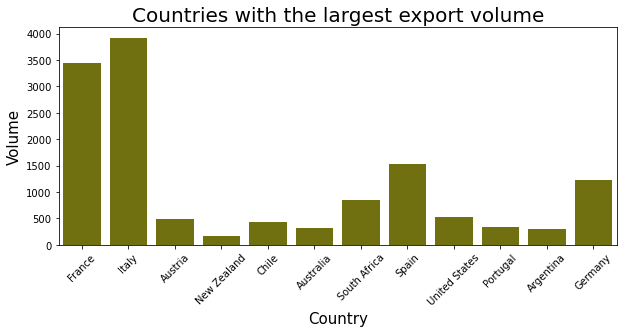

In [116]:
plt.figure(figsize=(10,4))

country = wines.Country.value_counts()[:12]

graph = sns.countplot(x='Country', 
                  data=wines[wines.Country.isin(LEV_countries.index.values)],
                 color='olive')
graph.set_title("Countries with the largest export volume", fontsize=20)
graph.set_xlabel("Country", fontsize=15)
graph.set_ylabel("Volume", fontsize=15)
graph.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.show()


### Rating

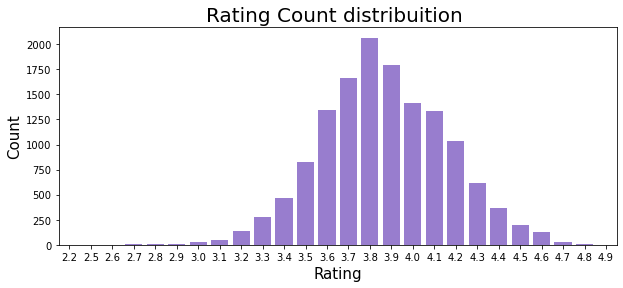

In [117]:
plt.figure(figsize=(10, 4))
graph = sns.countplot(x='Rating', data=wines, color='mediumpurple')
graph.set_title("Rating Count distribuition ", fontsize=20)
graph.set_xlabel("Rating", fontsize=15) 
graph.set_ylabel("Count", fontsize=15)
plt.show()

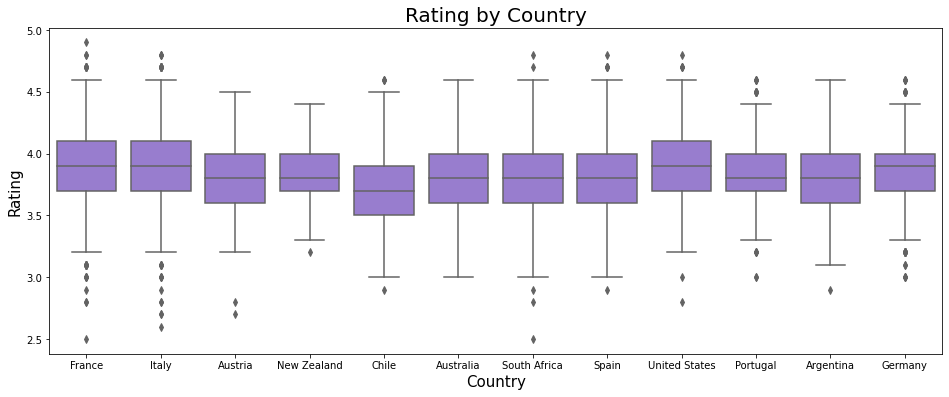

In [16]:
plt.figure(figsize=(16,6))

graph = sns.boxplot(x='Country', y='Rating',
                 data=wines[wines.Country.isin(LEV_countries.index.values)],
                 color='mediumpurple')
graph.set_title("Rating by Country", fontsize=20)
graph.set_xlabel("Country", fontsize=15)
graph.set_ylabel("Rating", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels())

plt.show()

Let's find regions and wineries with the highest average rating and produce quite a lot of bottles<br>
If you find wine from there in the store it's probably worth a try

In [17]:
MP_regions = wines['Region'].value_counts()[:100].index #most productive wineries
print(wines[wines['Region'].isin(MP_regions)].groupby('Region').Rating.mean().sort_values(ascending=False)[:20])
#Regions with the best rating from most productive onece

Region
Brunello di Montalcino                 4.253571
Amarone della Valpolicella Classico    4.242222
Hermitage                              4.236111
Pauillac                               4.222581
Saint-Julien                           4.188182
Amarone della Valpolicella             4.183784
Châteauneuf-du-Pape                    4.171000
Pessac-Léognan                         4.132955
Napa Valley                            4.131034
Primitivo di Manduria                  4.114516
Pomerol                                4.111864
Barolo                                 4.111429
Priorat                                4.105263
Champagne                              4.102281
Margaux                                4.083486
Saint-Émilion Grand Cru                4.079710
Gigondas                               4.062222
Barossa Valley                         4.031579
Saint-Estèphe                          4.026027
Ribera del Duero                       4.004217
Name: Rating, dtype: float64


In [18]:
MP_wineries = wines['Winery'].value_counts()[:100].index #most productive wineries
print(wines[wines['Winery'].isin(MP_wineries)].groupby('Winery').Rating.mean().sort_values(ascending=False)[:20])
#wineries with the best rating from most productive onece

Winery
Gaja                          4.366667
Louis Roederer                4.344444
Château Léoville Las Cases    4.321053
Antinori                      4.163889
Vietti                        4.118182
Domaine de la Janasse         4.085714
Bellavista                    4.083333
Morgenster Estate             4.083333
Ceretto                       4.063158
Château de Saint Cosme        4.054545
Penfolds                      4.048387
Tardieu-Laurent               4.042857
San Marzano                   4.026087
Delas                         4.016667
M. Chapoutier                 4.011905
Markus Molitor                4.009589
Von Winning                   4.008824
E. Guigal                     3.994444
Robert Mondavi                3.988235
St. Michael-Eppan             3.988000
Name: Rating, dtype: float64


### Price

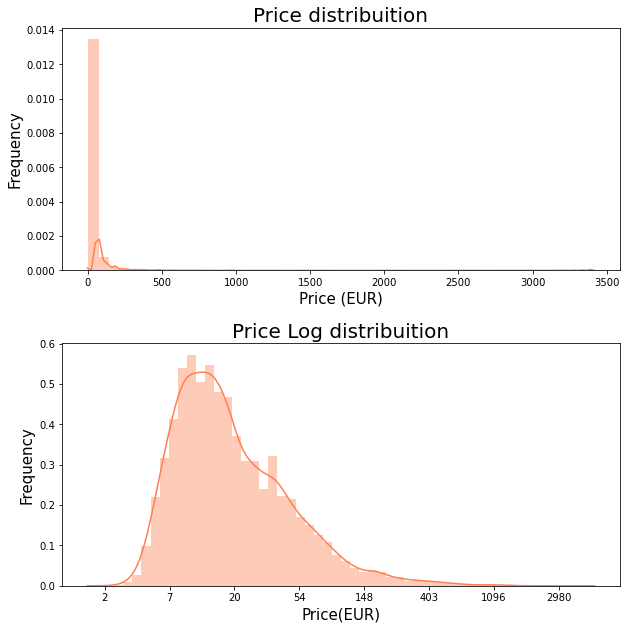

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
graph = sns.distplot(wines['Price'], color='coral')
graph.set_title("Price distribuition", fontsize=20) # seting title and size of font
graph.set_xlabel("Price (EUR)", fontsize=15) # seting xlabel and size of font
graph.set_ylabel("Frequency", fontsize=15) # seting ylabel and size of font

plt.subplot(2,1,2)
graph1 = sns.distplot(np.log(wines['Price']) , color='coral')
graph1.set_title("Price Log distribuition", fontsize=20) # seting title and size of font
graph1.set_xlabel("Price(EUR)", fontsize=15) # seting xlabel and size of font
graph1.set_ylabel("Frequency", fontsize=15) # seting ylabel and size of font
graph1.set_xticklabels(np.exp(graph1.get_xticks()).astype(int))

plt.subplots_adjust(hspace = 0.3,top = 0.9)
plt.show()

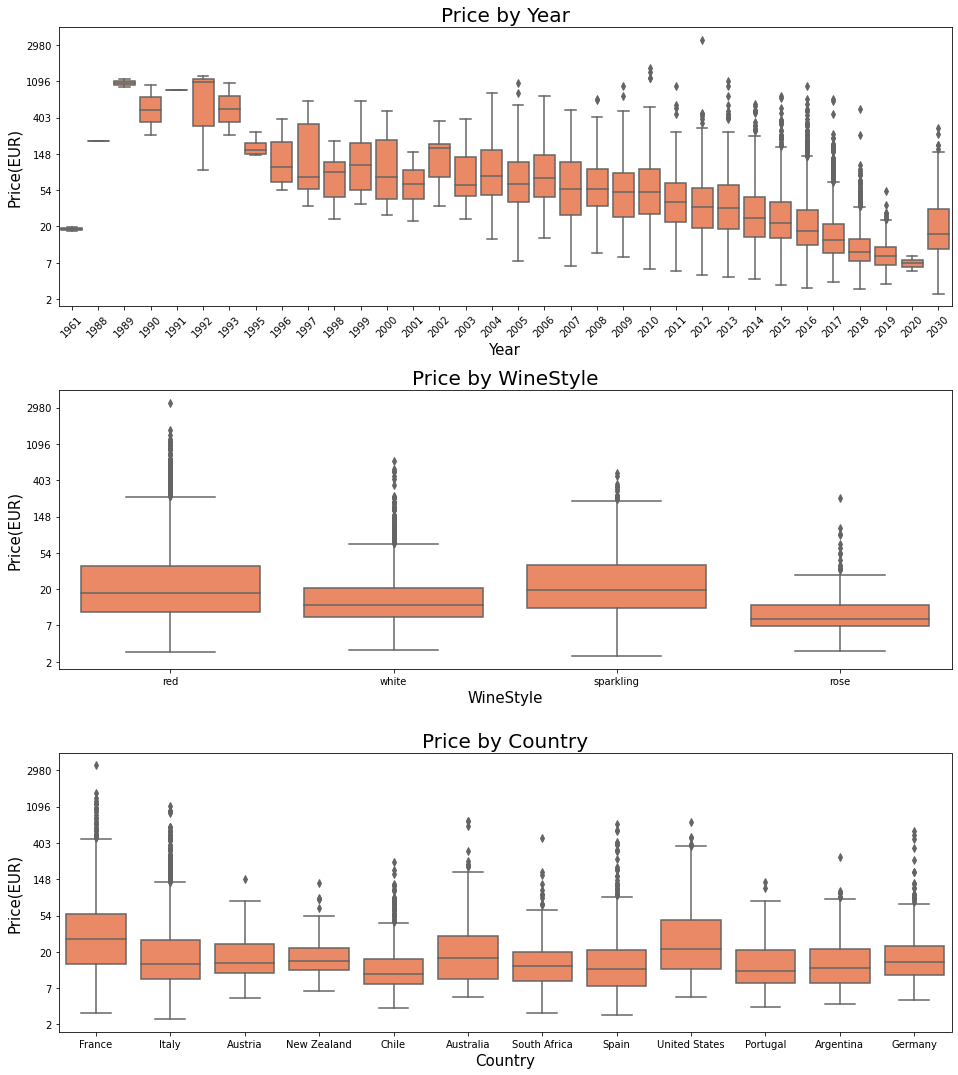

In [20]:
plt.figure(figsize=(16,18))

plt.subplot(3,1,1)
graph = sns.boxplot(x='Year', y=np.log(wines['Price']),
                    data=wines,
                    color='coral')
graph.set_title("Price by Year", fontsize=20)
graph.set_xlabel("Year", fontsize=15)
graph.set_ylabel("Price(EUR)", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels(),rotation=45)
graph.set_yticklabels(np.exp(graph.get_yticks()).astype(int))

plt.subplot(3,1,2)
graph1 = sns.boxplot(x='WineStyle', y=np.log(wines['Price']),
                 data=wines,
                 color='coral')
graph1.set_title("Price by WineStyle", fontsize=20)
graph1.set_xlabel("WineStyle", fontsize=15)
graph1.set_ylabel("Price(EUR)", fontsize=15)
graph1.set_xticklabels(graph1.get_xticklabels())
graph1.set_yticklabels(np.exp(graph1.get_yticks()).astype(int))

plt.subplot(3,1,3)
graph2 = sns.boxplot(x='Country', y=np.log(wines['Price']),
                 data=wines[wines.Country.isin(LEV_countries.index.values)],
                 color='coral')
graph2.set_title("Price by Country", fontsize=20)
graph2.set_xlabel("Country", fontsize=15)
graph2.set_ylabel("Price(EUR)", fontsize=15)
graph2.set_yticklabels(np.exp(graph2.get_yticks()).astype(int))

plt.subplots_adjust(hspace = 0.3, top = 0.9)

plt.show()

### Other plots

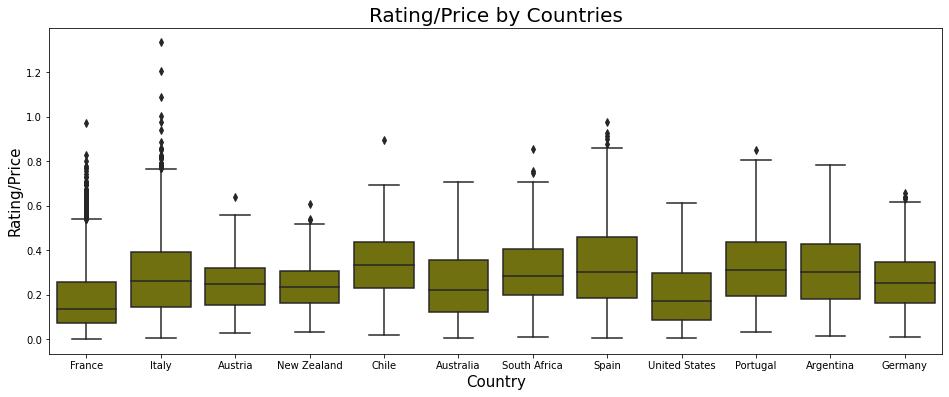

In [21]:
plt.figure(figsize=(16,6))
graph = sns.boxplot(x='Country', y=wines['Rating']/wines['Price'],
                 data=wines[wines.Country.isin(LEV_countries.index.values)],
                 color='olive')
graph.set_title("Rating/Price by Countries", fontsize=20)
graph.set_xlabel("Country", fontsize=15)
graph.set_ylabel("Rating/Price", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels())

plt.show()

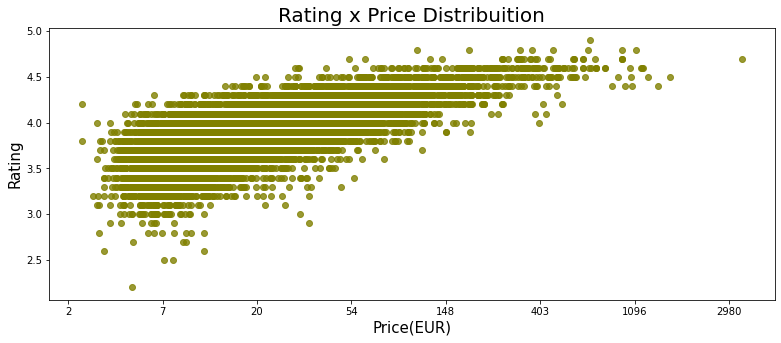

In [22]:
plt.figure(figsize=(13,5))

graph = sns.regplot(x=np.log(wines['Price']), y='Rating', 
                    data=wines, fit_reg=False, color='olive')
graph.set_title("Rating x Price Distribuition", fontsize=20)
graph.set_xlabel("Price(EUR)", fontsize= 15)
graph.set_ylabel("Rating", fontsize= 15)
graph.set_xticklabels(np.exp(graph.get_xticks()).astype(int))

plt.show()

Many people think, that good wine must be expensive. Of course, there is a tendency of average rating increasing when the price increases, but there are a lot of wines with 4+ rating just for 7 euros and 4.4+ rating for 20 euro. So, you can find a good wine for any wallet.

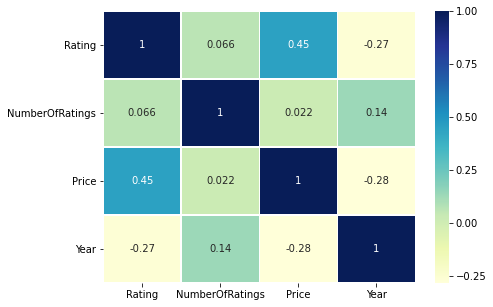

In [23]:
corrs = wines[['Rating','NumberOfRatings','Price','Year']].corr() #Heatmap for numetric columns
fig, ax = plt.subplots(figsize=(7,5))        

sns.heatmap(corrs,annot = True,ax=ax,linewidths=.6, cmap = 'YlGnBu');

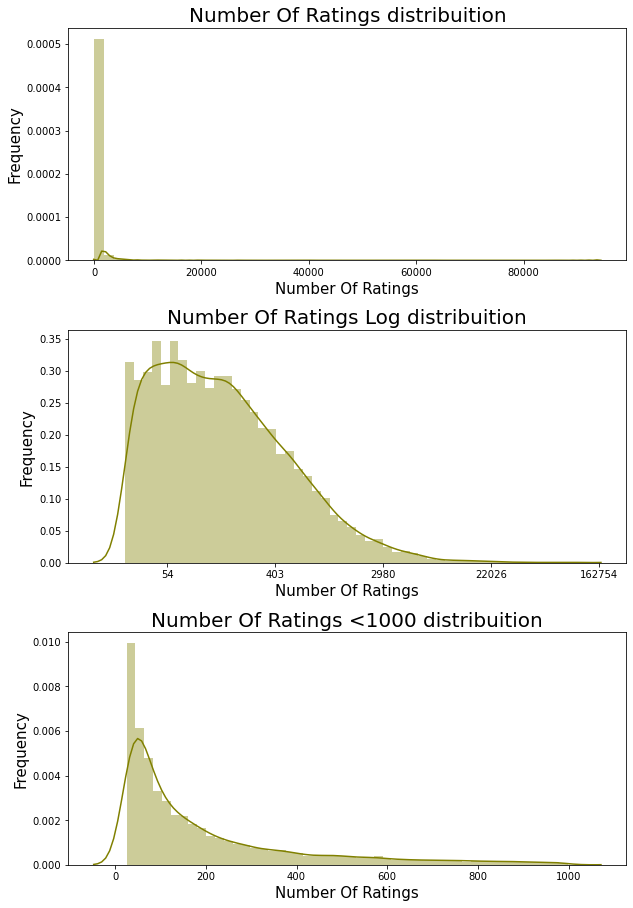

In [24]:
plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
graph = sns.distplot(wines['NumberOfRatings'], color='olive')
graph.set_title("Number Of Ratings distribuition", fontsize=20) 
graph.set_xlabel("Number Of Ratings", fontsize=15)
graph.set_ylabel("Frequency", fontsize=15) 

plt.subplot(3,1,2)
graph1 = sns.distplot(np.log(wines['NumberOfRatings']), color='olive')
graph1.set_title("Number Of Ratings Log distribuition", fontsize=20) 
graph1.set_xlabel("Number Of Ratings", fontsize=15) 
graph1.set_ylabel("Frequency", fontsize=15)
graph1.set_xticklabels(np.exp(graph1.get_xticks()).astype(int))

plt.subplot(3,1,3)
graph = sns.distplot(wines[wines['NumberOfRatings']<1000]['NumberOfRatings'], color='olive')
graph.set_title("Number Of Ratings <1000 distribuition", fontsize=20)
graph.set_xlabel("Number Of Ratings", fontsize=15) 
graph.set_ylabel("Frequency", fontsize=15) 

plt.subplots_adjust(hspace = 0.3,top = 0.9)
plt.show()

From the last graphics we can see, that Number of Ratings has the exponential distribution and there a lot of wines, which has low Number of Ratings(at Vivino and in this dataset you can see rating of wines which has more than 25 ratings). There is a real problem for business, because the main reason of Vivino app is to give info about quality of wine to customers, but for huge number of wines there are no rating at all. <br>
My idea is to apply ML methods to predict rating of wines wich has less than 25 ratings.

# 3) Feature Engineering

### Feature Generation

First glance, there is no information about variety in dataset.<br>
Usually, wine's names also contains variety<br>
I have parsed about 1500 wine varieties from wine-searcher.com and wiki.<br>
Will look for entries of variety from lists in Name column.<br>

In [25]:
varieties = pd.read_csv('Varieties.csv')

In [26]:
wines['Variety'] = np.nan
for index in wines.index:
    for variety in varieties['Variety']:    
        if variety in wines.loc[index, 'Name']:
            wines.loc[index, 'Variety'] = variety
            break

In [27]:
print('Now we have variety for', wines.Variety.notna().sum(),'wines,',
      '%s%%' % int(wines.Variety.notna().sum()/len(wines)*100), 'of all')

Now we have variety for 5768 wines, 41% of all


In [28]:
# replace NaN's
wines.Variety = wines.Variety.fillna('unknown')

In [29]:
wines.Variety.value_counts().head(20)

unknown               8066
Riesling               699
Chardonnay             558
Cabernet Sauvignon     557
Sauvignon Blanc        357
Merlot                 275
Pinot Noir             271
Shiraz                 234
Brunello               172
Syrah                  172
Malbec                 163
Primitivo              123
Prosecco               120
Barbera                119
Tempranillo            117
Montepulciano          108
Grüner Veltliner        93
Pinot Grigio            91
Pinotage                80
Zinfandel               67
Name: Variety, dtype: int64

### Encode categorical features

In [30]:
wines_enc = wines.copy().drop(columns = ['Name'])

In [31]:
#One-hot encoder for winestyle
wines_enc = pd.get_dummies(wines_enc, columns = ['WineStyle'])

In [32]:
wines_enc.head()

,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Variety,WineStyle_red,WineStyle_rose,WineStyle_sparkling,WineStyle_white
0,France,Pomerol,Château La Providence,4.2,100,95.00,2011,unknown,1,0,0,0
1,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,unknown,1,0,0,0
2,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,unknown,1,0,0,0
3,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,unknown,1,0,0,0
4,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,Pinot Noir,1,0,0,0


In [33]:
categorical_cols = [col for col in wines_enc.columns if wines_enc[col].dtype == "object"]

In [34]:
# Apply label encoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    wines_enc[col] = label_encoder.fit_transform(wines_enc[col])

In [35]:
wines_enc.head()

,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Variety,WineStyle_red,WineStyle_rose,WineStyle_sparkling,WineStyle_white
0,10,574,791,4.2,100,95.00,2011,208,1,0,0,0
1,10,404,891,4.3,100,15.50,2017,208,1,0,0,0
2,16,748,2809,3.9,100,7.45,2015,208,1,0,0,0
3,16,61,559,3.5,100,8.72,2019,208,1,0,0,0
4,2,143,2289,3.9,100,29.15,2016,146,1,0,0,0


# 4) Modeling

In [36]:
y = wines_enc['Rating']
X = wines_enc.drop(['Rating'], axis = 1)

In [38]:
kfolds = KFold(n_splits=6, shuffle=True, random_state=0)

In [39]:
def cv_mae(model, X=X, y=y):
    mae = -cross_val_score(model, X, y,
                          scoring="neg_mean_absolute_error",
                          cv=kfolds)
    return mae

In [40]:
lightgbm = LGBMRegressor(objective='regression',
                         metric='mean_absolute_error',
                         num_leaves=10,
                         learning_rate=0.05,
                         n_estimators=3000,
                         max_depth=5,
                         max_bin=400,
                         bagging_fraction=0.75,                         
                         bagging_freq=5,
                         bagging_seed=7,
                         reg_alpha=0.7,
                         reg_lambda=1.2,
                         feature_fraction=0.6,
                         feature_fraction_seed=7,
                         verbose=-1,
                         min_data_in_leaf=3,
                         min_sum_hessian_in_leaf=11
                         )
xgboost = XGBRegressor(n_estimators=3000,
                       learning_rate=0.02,
                       max_depth=5, 
                       min_child_weight=2,
                       subsample=0.8,
                       colsample_bytree=0.7,
                       nthread=-1,
                       gamma=0,
                       reg_alpha=0.1,
                       reg_lambda=1.8
                       )
catboost = CatBoostRegressor(iterations=3000,
                             learning_rate=0.03,
                             depth=6,
                             l2_leaf_reg = 2,
                             verbose=0
                            )

In [41]:
maes_lgbm = cv_mae(lightgbm)

In [42]:
print('Average lightgbm mae:', np.average(maes_lgbm), ' Standard deviation: ', np.std(maes_lgbm))

Average lightgbm mae: 0.13544626021758863  Standard deviation:  0.0019995704717354814


In [43]:
maes_xgb = cv_mae(xgboost)

In [44]:
print('Average xgboost mae:', np.average(maes_xgb), ' Standard deviation: ', np.std(maes_xgb))

Average xgboost mae: 0.13296254444498676  Standard deviation:  0.001761213680026176


In [45]:
maes_catboost = cv_mae(catboost)

In [46]:
print('Average catboost mae:', np.average(maes_catboost), ' Standard deviation: ', np.std(maes_catboost))

Average catboost mae: 0.13448912788556106  Standard deviation:  0.0022277512427167495


In [47]:
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,150,200,250,300]}
lasso_regressor = GridSearchCV(lasso,parameters,scoring='neg_mean_absolute_error',cv=kfolds)
lasso_regressor.fit(X,y)
print('Best lasso mae:', -lasso_regressor.best_score_,'with',lasso_regressor.best_params_)

Best lasso mae: 0.19971968291242226 with {'alpha': 1e-08}


In [48]:
ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,150,200,250,300]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_absolute_error',cv=kfolds)
ridge_regressor.fit(X,y)
print('Best ridge mae:', -ridge_regressor.best_score_,'with',ridge_regressor.best_params_)

Best ridge mae: 0.19971783299147103 with {'alpha': 35}


Wow! we has accuracy = 0.13 with boosting models, and of course it can be improved by bigger dataset size and more features which has Vivino company.

Gradient boosting shows significantly higher result than regresson models. Further, I will use lightgbm, because results are very close, but lightgbm is faster than xgboost. 

Now let's check our model predictions on wines with low, high and random Number of Ratings.

In [103]:
wines_enc['NumberOfRatings'].sort_values()[int(0.1*(len(wines_enc))):int(0.9*(len(wines_enc)))]

9241      35
9239      35
9243      35
9244      35
9245      35
        ... 
12329    827
12328    827
7978     827
7979     827
7980     828
Name: NumberOfRatings, Length: 11067, dtype: int64

In [107]:
wines_low_NumberOfRatings = wines_enc[wines_enc['NumberOfRatings']<35]
wines_high_NumberOfRatings = wines_enc[wines_enc['NumberOfRatings']>838]
wines_mid_NumberOfRatings = wines_enc[wines_enc['NumberOfRatings']>35][wines_enc['NumberOfRatings']<838]

In [108]:
X_low_NumberOfRatings_test = wines_low_NumberOfRatings.drop(['NumberOfRatings','Rating'], axis = 1)
y_low_NumberOfRatings_test = wines_low_NumberOfRatings['Rating']

X_high_NumberOfRatings_test = wines_high_NumberOfRatings.drop(['NumberOfRatings','Rating'], axis = 1)
y_high_NumberOfRatings_test = wines_high_NumberOfRatings['Rating']

X_mid = wines_mid_NumberOfRatings.drop(['NumberOfRatings','Rating'], axis = 1)
y_mid = wines_mid_NumberOfRatings['Rating']
X_train, X_random_test, y_train, y_random_test = train_test_split(X_mid, y_mid, test_size=len(X_low_NumberOfRatings_test))

In [111]:
print('Train data size:', len(X_train))
print('Test data sizes:', len(X_low_NumberOfRatings_test), len(X_high_NumberOfRatings_test), len(X_random_test))

Train data size: 9614
Test data sizes: 1369 1366 1369


In [112]:
lgbm = lightgbm.fit(X_train, y_train)

In [113]:
res_low_NumberOfRatings = lgbm.predict(X_low_NumberOfRatings_test)
res_high_NumberOfRatings = lgbm.predict(X_high_NumberOfRatings_test)
res_random_NumberOfRatings = lgbm.predict(X_random_test)

In [114]:
print('MAE of predictions with low NumberOfRatings:   ', mean_absolute_error(y_low_NumberOfRatings_test, res_low_NumberOfRatings))
print('MAE of predictions with high NumberOfRatings:  ', mean_absolute_error(y_high_NumberOfRatings_test, res_high_NumberOfRatings))
print('MAE of predictions with middle NumberOfRatings:', mean_absolute_error(y_random_test, res_random_NumberOfRatings))

MAE of predictions with low NumberOfRatings:    0.17357495783557417
MAE of predictions with high NumberOfRatings:   0.11727068321808792
MAE of predictions with middle NumberOfRatings: 0.13423608433013262


As we expected, rating of wines with low Number of Ratings is less representative, and accuracy of model is lower